## Machine Learning 101 code for Zhao nano lab
Author: Jiaheng Cui

Permanent contact: cuijhhebei@foxmail.com, https://jimcui3.github.io

Thanks to Beibei Xu, Dan Luo, Yanjun Yang for their contribution.

Thanks to Professor Yiping Zhao, Professor Xianyan Chen for their guidance.

#### Import the required packages.

Note: If you don't have plotly, and tqdm, please install them using the following code:

In [1]:
# pip install plotly

In [2]:
# pip install tqdm

In [47]:
import os
import linecache

import random
import math
import copy
import sys
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm import tqdm
from tqdm import trange

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from joblib import parallel_backend

#### Identify the working path.
This should be the folder of your entire project. In this folder, there should be several sub-folders like "data", "results", "documents", etc.

In [48]:
WORKING_PATH = r"E:\python\Jupyter\PhD\Raman Spectrum\ACE2\New Data\data"

#### Read the whole dataset.
We assume the dataset is **one csv file** containing all the spectra.

This csv file must satisfy:
1. Every row is a spectrum.
2. Every column except for the last two represents a wavenumber.
3. The header of the last two columns are ```Label``` (virus type) and ```Conc``` (concentration).

If you have multiple txt files or csv files, please use corresponding code **(to be done)** to process it first.

Please remember to change the path in ```r' '```, and the path should begin with ```\```.

In [49]:
df = pd.read_csv(WORKING_PATH + r'\ACE2_Virus - reference conc 0.csv')
df

,600,601,602,603,604,605,606,607,608,609,...,1792,1793,1794,1795,1796,1797,1798,1799,Label,Conc
0,0.422161,0.429406,0.430937,0.427536,0.411356,0.410965,0.416854,0.429240,0.455785,0.471315,...,0.063934,0.053561,0.025006,0.008210,0.000000,0.008733,0.013845,0.017511,NL63,3125
1,0.463677,0.471197,0.477259,0.482261,0.483432,0.491607,0.503482,0.519421,0.540681,0.563566,...,0.025088,0.022421,0.010759,0.003800,0.000000,0.002097,0.004047,0.006305,NL63,3125
2,0.415604,0.418119,0.423079,0.430693,0.442260,0.453965,0.467139,0.481675,0.497088,0.514514,...,0.001531,0.002019,0.011773,0.015445,0.014982,0.004704,0.000344,0.000000,NL63,3125
3,0.449221,0.452507,0.460582,0.473118,0.497380,0.508649,0.515675,0.518678,0.510932,0.516142,...,0.009663,0.003110,0.000000,0.000508,0.004152,0.013508,0.017811,0.017857,NL63,3125
4,0.381609,0.383951,0.389357,0.397648,0.410978,0.422035,0.433541,0.445745,0.454862,0.473865,...,0.004180,0.000000,0.006026,0.009590,0.011990,0.010471,0.009982,0.009549,NL63,3125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12540,0.822625,0.818181,0.811488,0.803505,0.787927,0.787821,0.795041,0.809109,0.838180,0.852828,...,0.000000,0.001237,0.011519,0.020804,0.029233,0.037164,0.038309,0.033331,Buffer-DMEM,0
12541,0.867162,0.855383,0.853354,0.862082,0.890314,0.910491,0.931587,0.952371,0.972760,0.989740,...,0.022417,0.027507,0.029713,0.028091,0.022925,0.012274,0.004671,0.000000,Buffer-DMEM,0
12542,0.544472,0.535942,0.537342,0.548613,0.581586,0.596059,0.605510,0.609259,0.601694,0.600922,...,0.028902,0.030512,0.047714,0.051474,0.045858,0.020397,0.006096,0.000000,Buffer-DMEM,0
12543,0.586184,0.582992,0.585441,0.593111,0.617572,0.620573,0.616270,0.605626,0.575413,0.573136,...,0.016489,0.015499,0.017404,0.016534,0.013821,0.007363,0.002944,0.000000,Buffer-DMEM,0


In [50]:
wavenumbers = np.array([float(x) for x in df.columns.tolist()[:-2]])
wavenumbers

array([ 600.,  601.,  602., ..., 1797., 1798., 1799.])

In [51]:
labels = np.unique(df['Label'])
labels

array(['229E', 'ACE2-BSA', 'Buffer-DMEM', 'CoV2', 'CoV2B1', 'NL63'],
      dtype=object)

### Dimension Reduction
#### PCA

In [52]:
# Copy the spectra
x_data = df.drop(['Label', 'Conc'],axis=1)

# For potential data standardization
# x_data = StandardScaler().fit_transform(x_data)
x_data

,600,601,602,603,604,605,606,607,608,609,...,1790,1791,1792,1793,1794,1795,1796,1797,1798,1799
0,0.422161,0.429406,0.430937,0.427536,0.411356,0.410965,0.416854,0.429240,0.455785,0.471315,...,0.053458,0.065334,0.063934,0.053561,0.025006,0.008210,0.000000,0.008733,0.013845,0.017511
1,0.463677,0.471197,0.477259,0.482261,0.483432,0.491607,0.503482,0.519421,0.540681,0.563566,...,0.015272,0.023512,0.025088,0.022421,0.010759,0.003800,0.000000,0.002097,0.004047,0.006305
2,0.415604,0.418119,0.423079,0.430693,0.442260,0.453965,0.467139,0.481675,0.497088,0.514514,...,0.015766,0.005529,0.001531,0.002019,0.011773,0.015445,0.014982,0.004704,0.000344,0.000000
3,0.449221,0.452507,0.460582,0.473118,0.497380,0.508649,0.515675,0.518678,0.510932,0.516142,...,0.031508,0.018955,0.009663,0.003110,0.000000,0.000508,0.004152,0.013508,0.017811,0.017857
4,0.381609,0.383951,0.389357,0.397648,0.410978,0.422035,0.433541,0.445745,0.454862,0.473865,...,0.031254,0.013973,0.004180,0.000000,0.006026,0.009590,0.011990,0.010471,0.009982,0.009549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12540,0.822625,0.818181,0.811488,0.803505,0.787927,0.787821,0.795041,0.809109,0.838180,0.852828,...,0.016495,0.004730,0.000000,0.001237,0.011519,0.020804,0.029233,0.037164,0.038309,0.033331
12541,0.867162,0.855383,0.853354,0.862082,0.890314,0.910491,0.931587,0.952371,0.972760,0.989740,...,0.005221,0.015354,0.022417,0.027507,0.029713,0.028091,0.022925,0.012274,0.004671,0.000000
12542,0.544472,0.535942,0.537342,0.548613,0.581586,0.596059,0.605510,0.609259,0.601694,0.600922,...,0.048679,0.033708,0.028902,0.030512,0.047714,0.051474,0.045858,0.020397,0.006096,0.000000
12543,0.586184,0.582992,0.585441,0.593111,0.617572,0.620573,0.616270,0.605626,0.575413,0.573136,...,0.022014,0.018261,0.016489,0.015499,0.017404,0.016534,0.013821,0.007363,0.002944,0.000000


Please note the number of components (`numofcomponents`) should be less than the number of data, also less than the number of features.

In [53]:
# numofcomponents should be less than number of data, and number of features
numofcomponents = 20

pca = PCA(n_components=numofcomponents)

pcs = pca.fit_transform(x_data)
pcs_df = pd.DataFrame(data = pcs, columns = ["PC"+str(x) for x in range(1,numofcomponents+1)])
pcs_df['Label'] = df['Label'].values.ravel()
pcs_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,Label
0,2.300675,-0.123629,-0.122511,2.922503,-0.713890,0.022140,-0.852378,0.480535,0.025736,-0.002349,...,0.035176,-0.084321,0.069635,-0.061900,0.033732,-0.023658,0.051607,0.069434,0.191232,NL63
1,2.032997,0.534303,0.679455,2.481489,-0.839273,0.416250,-1.199057,0.108196,-0.339551,-0.033511,...,-0.005308,-0.121574,0.071309,-0.032960,0.166243,-0.134367,0.023797,-0.023246,-0.072685,NL63
2,1.714587,0.475767,0.840302,2.008219,-0.701328,0.180874,-0.486488,0.023913,-0.189719,0.110198,...,0.146242,0.206210,0.098646,-0.038802,-0.091838,0.040894,-0.032877,-0.183960,0.076300,NL63
3,0.424711,0.897446,1.473666,0.734416,-0.591294,-0.123089,0.076164,0.930996,0.564390,-0.659526,...,0.705037,0.097075,0.082660,0.121587,-0.178745,0.067101,0.119377,-0.075451,-0.013388,NL63
4,1.442368,-0.129074,0.357970,2.350665,-0.748157,0.106973,-0.675399,0.598899,0.015835,-0.015261,...,-0.038546,0.031242,0.173629,-0.031610,0.108706,-0.077832,0.027949,0.044995,-0.018738,NL63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12540,-6.997790,0.866668,1.449484,-2.452607,-0.675908,-0.103439,0.174124,0.213658,0.084676,-0.242774,...,0.019823,-0.083499,0.005649,0.002238,-0.028393,-0.018081,-0.045697,0.043649,0.018519,Buffer-DMEM
12541,-5.262711,1.474198,2.139615,-1.737566,-0.751164,0.194670,-1.177035,-0.601515,-0.727554,-0.084524,...,0.310397,0.094387,-0.070881,-0.262921,0.068049,-0.005621,0.120956,0.152132,0.123071,Buffer-DMEM
12542,-5.023948,-1.057714,-1.103717,0.557712,0.102912,-0.540981,0.259715,0.152098,0.102837,-0.137062,...,-0.345932,-0.069334,-0.008630,-0.016690,-0.044178,-0.002002,0.104610,0.136721,0.042066,Buffer-DMEM
12543,-6.011769,-1.557977,-0.698594,0.248516,0.447831,-0.428111,0.440341,0.097533,-0.256337,-0.145064,...,-0.052225,-0.219018,-0.113122,-0.101492,-0.047974,-0.077098,-0.021885,0.021393,-0.029599,Buffer-DMEM


In [24]:
# Save pcs_df
# pd.DataFrame(pcs_df).to_csv(WORKING_PATH + "/result/pcs_df.csv",index=False)

In [54]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
var=np.cumsum(pca.explained_variance_ratio_)

Explained variation per principal component: [7.14020230e-01 1.52853932e-01 5.14403616e-02 2.89824009e-02
 1.53812603e-02 8.97520840e-03 6.12319900e-03 2.89324290e-03
 2.70713957e-03 1.77411725e-03 1.63229354e-03 1.08852942e-03
 7.79365365e-04 7.49681274e-04 5.61993270e-04 4.42052018e-04
 3.67971945e-04 3.15732101e-04 2.81823499e-04 2.37183575e-04]


#### Check to see if the sum of the first 2 or 3 PCs exceeds 85%. If not, the PCA will show limited information about the dataset, so please skip the PCA and refer to t-SNE.

In [55]:
print('Accumulated explained variation : {}'.format(var))

Accumulated explained variation : [0.71402023 0.86687416 0.91831452 0.94729692 0.96267819 0.97165339
 0.97777659 0.98066984 0.98337697 0.98515109 0.98678339 0.98787192
 0.98865128 0.98940096 0.98996295 0.99040501 0.99077298 0.99108871
 0.99137053 0.99160772]


Next, we will perform a PCA analysis. The result of PCA is a dimension reduction of the original data.

Remember that PCA serves to answer these questions:
1. After dimension reduction, can we easily see the boundaries between the data and thus classify them?
2. What classes overlap much? Will they be the places that misclassifications occur?

Draw PCA only according to the label (please do not have too many types of the substance), using automatic colors.

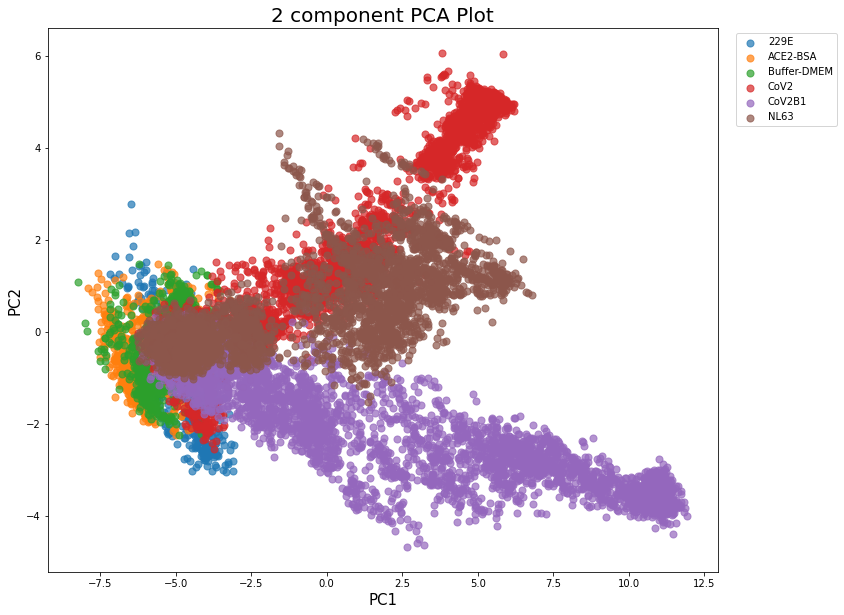

In [56]:
# Draw PC2 vs PC1 plot
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('2 component PCA Plot', fontsize = 20)
targets = np.unique(df['Label'])
for target in targets:
    indicesToKeep = pcs_df['Label'] == target
    ax.scatter(pcs_df.loc[indicesToKeep, 'PC1'], pcs_df.loc[indicesToKeep, 'PC2'], s = 50, alpha=0.7)

ax.legend(targets, bbox_to_anchor=(1.02, 1), loc='upper left')

Draw PCA according to the combination of (label, concentration), using 54 possible colors, i.e., # of combination of (label, concentration) shouldn't be more than 54. You can adjust the order of the colors to make substances from the same label having similar colors.

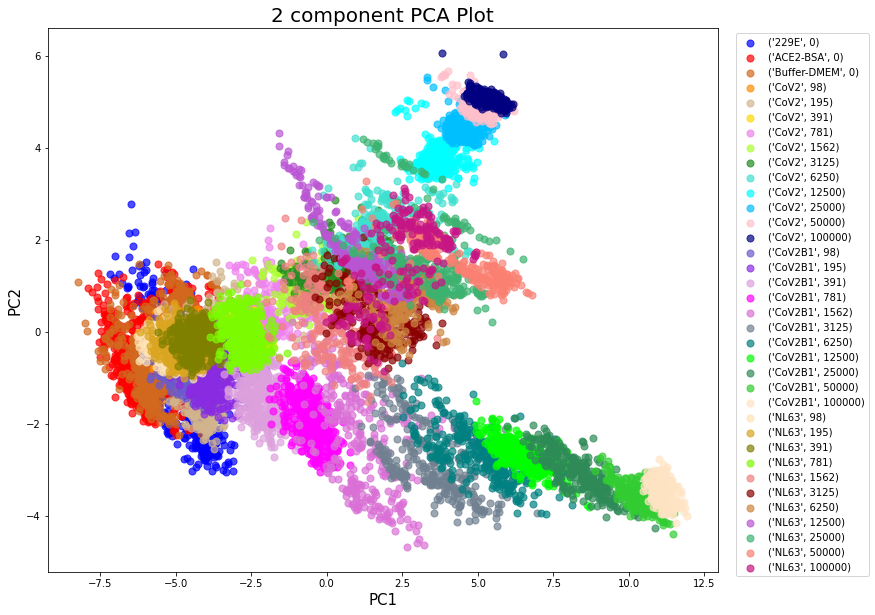

In [57]:
# Draw PC2 vs PC1 plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('PC1', fontsize=15)
ax.set_ylabel('PC2', fontsize=15)
ax.set_title('2 component PCA Plot', fontsize=20)

unique_combinations = df.groupby(['Label', 'Conc']).groups.keys()
colors = ['blue', 'red', 'chocolate', 'darkorange', 'tan', 'gold', 'violet', 'greenyellow', 'forestgreen',
          'turquoise', 'aqua', 'deepskyblue', 'pink', 'navy', 'slateblue', 'blueviolet', 'plum', 'fuchsia',
          'orchid', 'slategray', 'teal', 'lime', 'seagreen', 'limegreen', 'bisque', 'moccasin', 'goldenrod',
          'olive', 'lawngreen', 'lightcoral', 'darkred', 'peru', 'mediumorchid', 'mediumseagreen', 'salmon',
          'mediumvioletred', 'mediumturquoise', 'mediumspringgreen', 'mediumslateblue', 'mediumaquamarine',
          'lightseagreen', 'lightskyblue', 'lightgreen', 'lightgray', 'lightgoldenrodyellow', 'lightblue',
          'lemonchiffon', 'lavenderblush', 'indigo', 'hotpink', 'green', 'gold', 'firebrick', 'darkslategray']

for i, combination in enumerate(unique_combinations):
    label, conc = combination
    indicesToKeep = (df['Label'] == label) & (df['Conc'] == conc)
    ax.scatter(pcs_df.loc[indicesToKeep, 'PC1'], pcs_df.loc[indicesToKeep, 'PC2'], s=50, alpha=0.7, label=combination, c=colors[i])

ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

Visualize the first 3 PCs using plotly, it's an interactive plot.

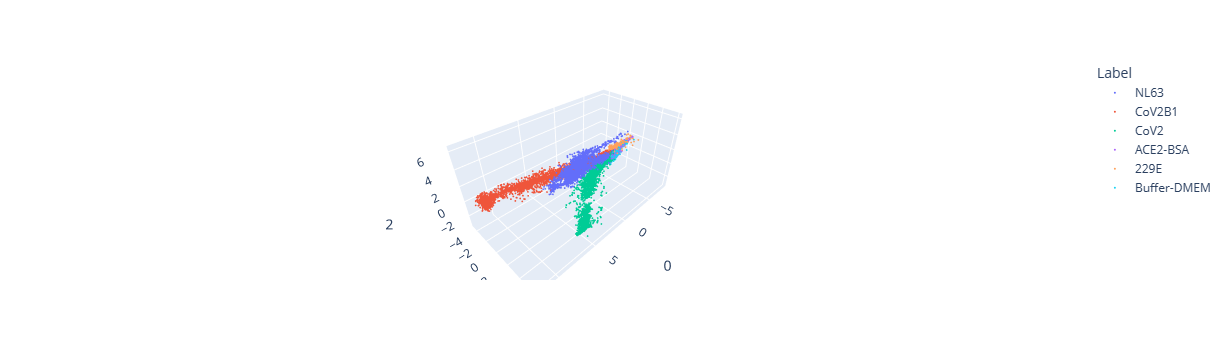

In [58]:
# Visualize the first 3 PCs
proj_3d = PCA(n_components=3).fit_transform(x_data)

fig_3d = px.scatter_3d(
    proj_3d, x=0, y=1, z=2,
    color=pcs_df['Label'], labels={'color': 'Label'}
)
fig_3d.update_traces(marker_size=1)

fig_3d.show()

Maybe you want to save the first 3 PCs by classes into a csv:

In [40]:
# Group the dataframe by the 'Label' column
grouped = pcs_df.groupby('Label')

# Create an empty list to store the dataframes for each class
class_dfs = []

# Iterate over each group and create a dataframe for each class
for label, group in grouped:
    # Create a new dataframe for the current class
    class_df = pd.DataFrame()
    class_df['{} - PC1'.format(label)] = group['PC1']
    class_df['{} - PC2'.format(label)] = group['PC2']
    class_df['{} - PC3'.format(label)] = group['PC3']
    
    class_df.reset_index(drop=True, inplace=True)
    # Add the dataframe to the list
    class_dfs.append(class_df)

# Concatenate the dataframes for all classes into a single dataframe
result_df = pd.concat(class_dfs, axis=1)
result_df

,229E - PC1,229E - PC2,229E - PC3,ACE2-BSA - PC1,ACE2-BSA - PC2,ACE2-BSA - PC3,Buffer-DMEM - PC1,Buffer-DMEM - PC2,Buffer-DMEM - PC3,CoV2 - PC1,CoV2 - PC2,CoV2 - PC3,CoV2B1 - PC1,CoV2B1 - PC2,CoV2B1 - PC3,NL63 - PC1,NL63 - PC2,NL63 - PC3
0,-6.445008,1.345769,1.974166,-6.088106,0.573277,1.189090,-6.180943,-0.632253,-0.066929,4.547982,4.260967,-1.395736,8.600677,-3.757401,-0.280747,2.300675,-0.123629,-0.122511
1,-6.042891,0.997478,1.874155,-6.548431,-1.225262,-0.680608,-4.352695,0.142702,-0.474517,4.522638,4.676008,-1.539037,7.088876,-2.986764,-0.192591,2.032997,0.534303,0.679455
2,-5.766035,0.712940,1.823092,-7.085701,-0.054208,0.725315,-4.752121,0.842819,0.142016,4.367263,4.458531,-1.672239,5.592408,-2.081690,-0.477170,1.714587,0.475767,0.840302
3,-5.763577,1.178447,2.003950,-5.520895,0.168133,0.574312,-4.148751,0.089286,0.033787,4.204211,4.594004,-1.437852,5.953054,-2.671061,0.476633,0.424711,0.897446,1.473666
4,-5.786965,0.915388,1.846623,-4.069012,-0.293878,-0.097287,-5.669161,-1.025594,-0.591749,4.320125,4.611539,-1.495380,7.223732,-2.302108,-0.148423,1.442368,-0.129074,0.357970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.336343,-1.772211,0.618437,NaN,NaN,NaN
3706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.652818,-1.896215,0.586419,NaN,NaN,NaN
3707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.795893,-2.086305,-0.022801,NaN,NaN,NaN
3708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.760021,-2.328889,-0.642522,NaN,NaN,NaN


In [41]:
# Save this dataframe
# pd.DataFrame(result_df).to_csv(WORKING_PATH + "/result/PCA_class_df.csv",index=False)

Maybe you want to save the first 3 PCs by the combination (classes, concentration) into a csv:

In [42]:
# Group the dataframe by the ('Label', 'Conc') columns
pcs_df_copy = pcs_df.copy()

pcs_df_copy['Conc'] = df['Conc']
unique_combinations = pcs_df_copy.groupby(['Label', 'Conc']).groups.keys()
class_dfs = []

# Save the PC1, PC2, and PC3 data for each combination
for combination in unique_combinations:
    label, conc = combination
    indicesToKeep = (pcs_df_copy['Label'] == label) & (pcs_df_copy['Conc'] == conc)
    combination_df = pcs_df_copy.loc[indicesToKeep, ['PC1', 'PC2', 'PC3']]
    combination_df.reset_index(drop=True, inplace=True)
    combination_df.columns = [f'{label}_{conc}_PC1', f'{label}_{conc}_PC2', f'{label}_{conc}_PC3']  # Set the column names
    class_dfs.append(combination_df)

result_df = pd.concat(class_dfs, axis=1)
result_df

,229E_0_PC1,229E_0_PC2,229E_0_PC3,ACE2-BSA_0_PC1,ACE2-BSA_0_PC2,ACE2-BSA_0_PC3,Buffer-DMEM_0_PC1,Buffer-DMEM_0_PC2,Buffer-DMEM_0_PC3,CoV2_98_PC1,...,NL63_12500_PC3,NL63_25000_PC1,NL63_25000_PC2,NL63_25000_PC3,NL63_50000_PC1,NL63_50000_PC2,NL63_50000_PC3,NL63_100000_PC1,NL63_100000_PC2,NL63_100000_PC3
0,-6.445008,1.345769,1.974166,-6.088106,0.573277,1.189090,-6.180943,-0.632253,-0.066929,-4.727779,...,4.275224,-0.270731,2.013902,4.074943,4.119994,1.625218,2.705944,4.234091,2.202350,2.571423
1,-6.042891,0.997478,1.874155,-6.548431,-1.225262,-0.680608,-4.352695,0.142702,-0.474517,-4.816150,...,4.211494,-0.463058,2.399415,4.064734,4.779303,1.422740,2.300809,1.806977,0.191686,2.685009
2,-5.766035,0.712940,1.823092,-7.085701,-0.054208,0.725315,-4.752121,0.842819,0.142016,-5.522376,...,4.070705,3.874582,2.109113,4.837139,5.940094,0.915991,1.937642,1.735480,0.150923,2.747609
3,-5.763577,1.178447,2.003950,-5.520895,0.168133,0.574312,-4.148751,0.089286,0.033787,-4.941861,...,3.811876,4.530406,1.899825,4.209017,5.578390,1.104980,2.290793,1.428582,0.333059,2.786466
4,-5.786965,0.915388,1.846623,-4.069012,-0.293878,-0.097287,-5.669161,-1.025594,-0.591749,-4.749051,...,3.603486,2.883325,2.721359,4.734146,5.369521,0.847150,2.096754,1.533039,0.291727,2.568666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,NaN,NaN,NaN,-5.004148,-2.227444,-1.758243,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
730,NaN,NaN,NaN,-6.336833,-1.342076,-0.523364,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
731,NaN,NaN,NaN,-5.054909,-1.105618,-0.769439,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
732,NaN,NaN,NaN,-5.767170,-0.995329,-0.533389,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# Save this dataframe
# pd.DataFrame(result_df).to_csv(WORKING_PATH + "/result/PCA_class_conc_df.csv",index=False)

Loadings are the contribution of each feature to each principal component.

In [59]:
loadings = pd.DataFrame(pca.components_.T, columns= ["PC"+str(x) for x in range(1,numofcomponents+1)])
loadings

# Save loadings
# pd.DataFrame(loadings).to_csv(WORKING_PATH + "/result/loadings.csv",index=False)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,-0.031742,0.022367,0.020133,-0.021041,-0.037996,0.010572,-0.062144,-0.043056,-0.013239,-0.015084,0.015368,-0.003850,-0.067686,-0.039494,0.010850,-0.035745,0.013536,-0.081652,0.010730,0.059772
1,-0.031663,0.023968,0.020116,-0.020250,-0.037436,0.011579,-0.063155,-0.040302,-0.013530,-0.011354,0.017915,-0.003568,-0.070708,-0.038233,0.008885,-0.032752,0.019890,-0.081520,0.006887,0.057114
2,-0.031559,0.024776,0.019923,-0.020152,-0.037151,0.012360,-0.064361,-0.037940,-0.015819,-0.009247,0.020904,-0.003934,-0.074956,-0.037328,0.007579,-0.031502,0.023666,-0.081895,0.004745,0.052037
3,-0.031409,0.024790,0.019558,-0.020692,-0.037151,0.012943,-0.065647,-0.036123,-0.020041,-0.009031,0.024064,-0.004721,-0.079982,-0.036887,0.006886,-0.031590,0.024618,-0.082482,0.004430,0.044920
4,-0.031235,0.023121,0.018680,-0.022904,-0.037703,0.013019,-0.067402,-0.034875,-0.028906,-0.012289,0.028513,-0.007317,-0.088449,-0.036171,0.007212,-0.035810,0.020503,-0.084868,0.007899,0.032763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,0.011142,0.045423,-0.052063,-0.022268,0.004268,-0.067077,-0.000145,0.008078,-0.026845,-0.000614,-0.019480,0.010365,-0.003193,-0.029807,-0.046544,-0.022622,0.021260,-0.039535,0.034370,-0.005416
1196,0.011131,0.045237,-0.052213,-0.022232,0.004584,-0.066865,0.000656,0.007548,-0.025935,-0.002282,-0.020885,0.009935,-0.001918,-0.032244,-0.047361,-0.023080,0.024034,-0.038065,0.034078,-0.005821
1197,0.011060,0.045834,-0.052357,-0.021596,0.004831,-0.066141,0.001780,0.008246,-0.022547,0.000197,-0.021240,0.013612,-0.002584,-0.034182,-0.046633,-0.020321,0.026562,-0.029876,0.037326,-0.015919
1198,0.011165,0.046040,-0.051974,-0.020676,0.004757,-0.066179,0.002132,0.007960,-0.019487,0.001303,-0.022126,0.016632,-0.002150,-0.032509,-0.045672,-0.018066,0.025775,-0.023616,0.038013,-0.019210


We can plot the loadings vs wavenumber to see which wavenumbers contribute most to which PC.

Please **indicate the start (`start_loading`, default: 1) and end loadings (`end_loading`, default: 3)** in the following code.

In [62]:
# Start and ending of the loadings to be drawn
start_loading = 1
end_loading = 2

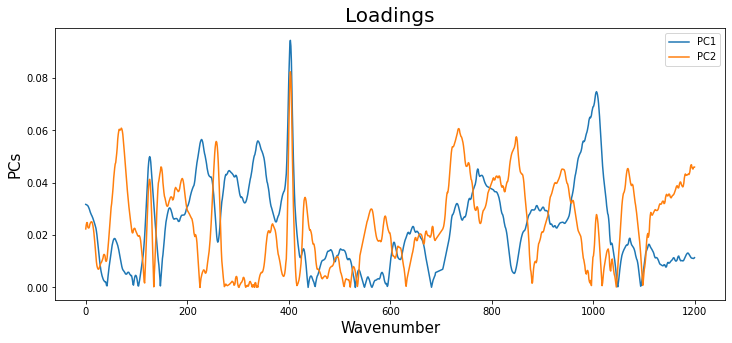

In [63]:
# Plot the loadings
fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(1,1,1) 

ax.set_xlabel('Wavenumber', fontsize = 15)
ax.set_ylabel('PCs', fontsize = 15)
ax.set_title('Loadings', fontsize = 20)
targets = ["PC"+str(x) for x in range(start_loading,end_loading+1)]
for target in targets:
    indicesToKeep = pcs_df['Label'] == target
    ax.plot(abs(loadings[target]))
ax.legend(targets)

#### t-SNE

Typically, t-SNE will have a better performance dealing with high-dimension data like spectra than PCA.

**n_components**: In most cases, `n_components = 2`. However, you may also try `n_components = 3`.

**perplexity**: Typical values for `perplexity` range from 5 to 50, it often requires trial and error to find a suitable perplexity value that reveals the desired structure in the data. A high perplexity value encourages t-SNE to focus more on global structure, smoothing out the embeddings. A low perplexity value emphasizes local structure and can result in more compact clusters.

In [21]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, init='random', learning_rate='auto')
tsne_results = tsne.fit_transform(pcs_df.iloc[:, :-1])
print('t-SNE done!')

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 207 samples in 0.000s...
[t-SNE] Computed neighbors for 207 samples in 0.075s...
[t-SNE] Computed conditional probabilities for sample 207 / 207
[t-SNE] Mean sigma: 5.154064
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.802032
[t-SNE] KL divergence after 300 iterations: 0.106318
t-SNE done!


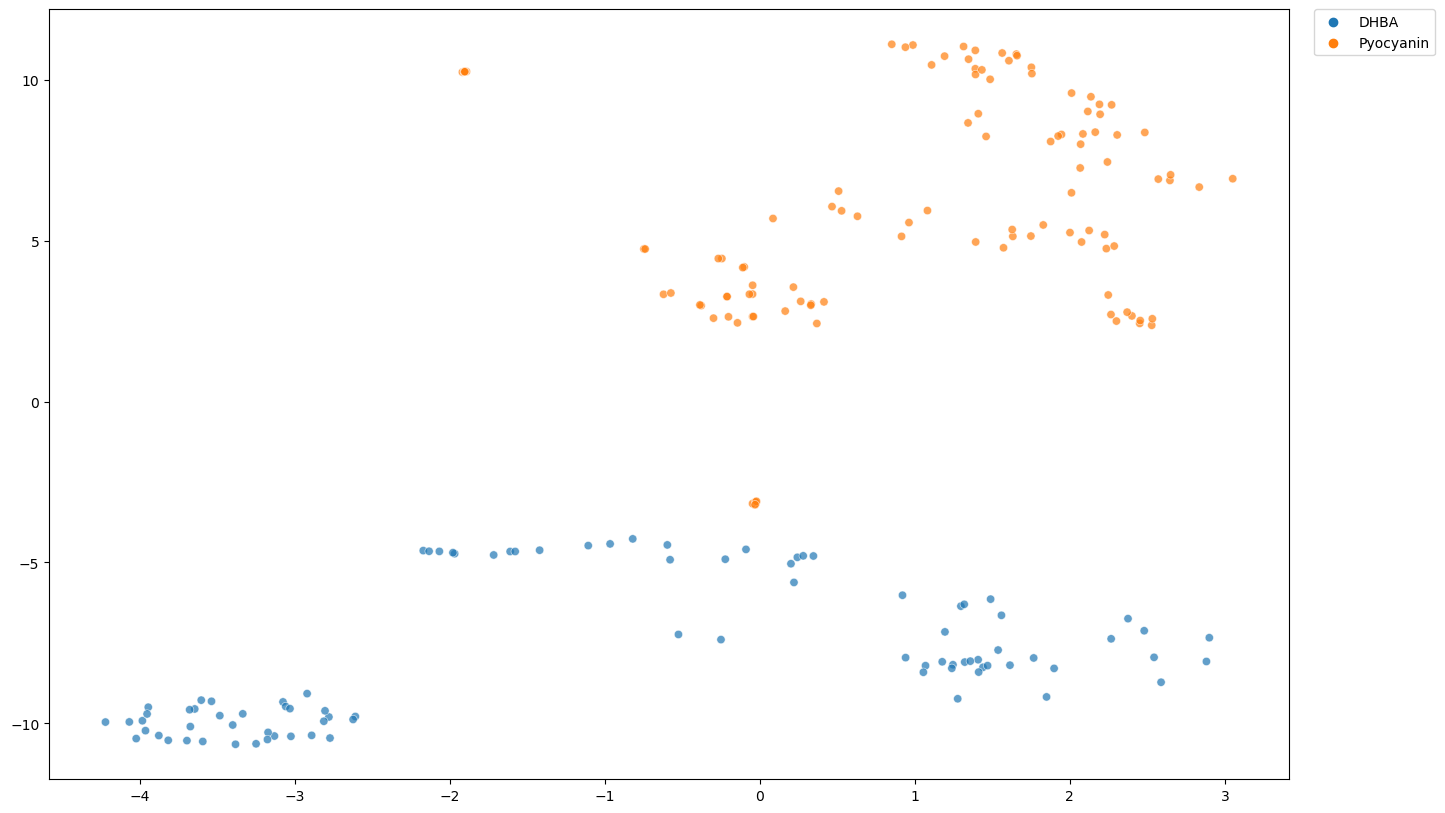

In [22]:
plt.figure(figsize=(16,10))

sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=df['Label'],
    alpha=0.7
)

# Move the legend outside the plot area
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

# Show the plot
plt.show()

Save the data for future use.

In [23]:
# Group the dataframe by the 'Label' column
tsne_df = pd.DataFrame(tsne_results)
tsne_df['Label'] = df['Label']
grouped = tsne_df.groupby('Label')

# Create an empty list to store the dataframes for each class
class_dfs = []

# Iterate over each group and create a dataframe for each class
for label, group in grouped:
    # Create a new dataframe for the current class
    class_df = pd.DataFrame()
    class_df['{} - 0'.format(label)] = group[0]
    class_df['{} - 1'.format(label)] = group[1]
    
    class_df.reset_index(drop=True, inplace=True)
    # Add the dataframe to the list
    class_dfs.append(class_df)

# Concatenate the dataframes for all classes into a single dataframe
result_df = pd.concat(class_dfs, axis=1)
result_df

,DHBA - 0,DHBA - 1,Pyocyanin - 0,Pyocyanin - 1
0,-2.890173,-10.373258,2.527640,2.370193
1,-3.334375,-9.704284,2.264843,2.703699
2,-3.381227,-10.650586,2.399822,2.661627
3,-3.644301,-9.552871,2.369142,2.777872
4,-3.961842,-10.226898,2.299983,2.501039
...,...,...,...,...
112,NaN,NaN,2.115573,9.015333
113,NaN,NaN,2.135578,9.471490
114,NaN,NaN,2.066453,7.259044
115,NaN,NaN,2.194840,8.926802


In [24]:
# Save this dataframe
# pd.DataFrame(result_df).to_csv(WORKING_PATH + "/result/t-SNE_class_df.csv",index=False)

### Dataset split

#### Stratified splitting training and testing data.

In [25]:
# Please adjust the proportions of test set (default = 10%).
proportion_test = 0.5

# split (train & val) and test.
train = df.groupby(['Label','Conc'], group_keys=False).apply(lambda x: x.sample(frac=1-proportion_test))
test = df.loc[df.index.difference(train.index)]
train.shape, test.shape

((93, 1402), (114, 1402))

**X** represents the spectra. Let's get spectra for training (`X_train`) and spectra for testing (`X_test`).

In [26]:
# Get X_train and X_test.
X_train, X_test = train.values[:,:-2],test.values[:,:-2]

# # standardize X if needed
# scaler1 = StandardScaler().fit(X_train)
# X_train = scaler1.transform(X_train)

# scaler2 = StandardScaler().fit(X_test)
# X_test = scaler2.transform(X_test)

X_train.shape, X_test.shape

((93, 1400), (114, 1400))

**y** represents the labels (`'Label'` and `'Conc'`). Since we may do classification and regression, and each task has training and testing set, we are going to get labels for classification training (`y_train_class`), labels for regression training (`y_train_reg`), labels for classification testing (`y_test_class`), and labels for regression testing (`y_test_reg`).

In classification, we match every data's label with a vector whose length = #(classes). For example, if we have three possible classes "A", "B", "C", then we can assign "A" = [1,0,0], "B" = [0,1,0], "C" = [0,0,1]. This is called One-hot encoding.

In [27]:
## Get y_train_class for classification
encoder = OneHotEncoder(sparse=False)

y_train_class = encoder.fit_transform((train['Label'].values).reshape(-1,1))
print("Original y_train_class:")
print((train['Label'].values).reshape(-1,1))
print("\nPossible classes:")
print(encoder.categories_)
print("\nOne-hot encoding of y_train_class:")
print(y_train_class)

Original y_train_class:
[['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyo

D:\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



Similarly, we can convert concentrations into a matrix. In each row (each spectrum), only the position representing the category of the data stores the concentration of that data, and the rest of the places are 0. This operation is called feature masking.

Note:
1. You can choose to use original concentration or log concentration (recommended).
2. If log concentration is used, all concentrations are added with `1e-20` (i.e, $10^{-20}$) to avoid $log(0)$. In this case, reference (concentration = $0$) will become $-20$ after the log transform.

In [69]:
# Get y_train_reg for regression
y_train_reg = np.ones(y_train_class.shape)
y_train_reg *= -50
for i in range(y_train_class.shape[0]):
#     # Use original concentration
#     y_train_reg[i][y_train_class[i]==1]=(train["Conc"].values)[i]
    # Use log concentration
    y_train_reg[i][y_train_class[i]==1]=np.log10((train['Conc'].values)[i] + 1e-50)

print("Originaly_train_class:")
print((train['Conc'].values).reshape(-1,1)+1e-20)
print("\nOne-hot encoding of y_train_class:")
print(y_train_class)
print("\nFeature masking of y_train_reg:")
print(y_train_reg)

Originaly_train_class:
[[1.9530e-03]
 [1.9530e-03]
 [1.9530e-03]
 [1.9530e-03]
 [3.9000e-03]
 [3.9000e-03]
 [3.9000e-03]
 [3.9000e-03]
 [7.8125e-03]
 [7.8125e-03]
 [7.8125e-03]
 [7.8125e-03]
 [9.0000e-03]
 [9.0000e-03]
 [9.0000e-03]
 [9.0000e-03]
 [1.5000e-02]
 [1.5000e-02]
 [1.5000e-02]
 [1.5000e-02]
 [3.1250e-02]
 [3.1250e-02]
 [3.1250e-02]
 [3.1250e-02]
 [6.2500e-02]
 [6.2500e-02]
 [6.2500e-02]
 [6.2500e-02]
 [1.2500e-01]
 [1.2500e-01]
 [1.2500e-01]
 [1.2500e-01]
 [2.0000e-01]
 [2.0000e-01]
 [2.0000e-01]
 [2.0000e-01]
 [5.0000e-01]
 [5.0000e-01]
 [5.0000e-01]
 [5.0000e-01]
 [3.1250e-05]
 [3.1250e-05]
 [3.1250e-05]
 [3.1250e-05]
 [6.2500e-05]
 [6.2500e-05]
 [6.2500e-05]
 [6.2500e-05]
 [6.2500e-05]
 [6.2500e-05]
 [6.2500e-05]
 [6.2500e-05]
 [6.2500e-05]
 [1.0000e-04]
 [1.0000e-04]
 [1.0000e-04]
 [1.0000e-04]
 [1.2500e-04]
 [1.2500e-04]
 [1.2500e-04]
 [1.2500e-04]
 [2.0000e-04]
 [2.0000e-04]
 [2.0000e-04]
 [2.0000e-04]
 [2.5000e-04]
 [2.5000e-04]
 [2.5000e-04]
 [2.5000e-04]
 [4.0000e-0

Similarly, we can get `y_test_class` and `y_test_reg`.

In [29]:
## Get y_test_class for classification
encoder = OneHotEncoder(sparse=False)

y_test_class = encoder.fit_transform((test['Label'].values).reshape(-1,1))
print("Original y_test_class:")
print((test['Label'].values).reshape(-1,1))
print("\nPossible classes:")
print(encoder.categories_)
print("\nOne-hot encoding of y_test_class:")
print(y_test_class)

Original y_test_class:
[['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['DHBA']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin']
 ['Pyocyanin

D:\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [70]:
# Get y_test_reg for regression
y_test_reg = np.ones(y_test_class.shape) * -50
for i in range(y_test_class.shape[0]):
#     # Use original concentration
#     y_test_reg[i][y_test_class[i]==1]=(test["Conc"].values)[i]
    # Use log concentration
    y_test_reg[i][y_test_class[i]==1]=np.log10((test['Conc'].values)[i] + 1e-50)

print("Originaly_test_class:")
print((test['Conc'].values).reshape(-1,1)+1e-20)
print("\nOne-hot encoding of y_test_class:")
print(y_test_class)
print("\nFeature masking of y_test_reg:")
print(y_test_reg)

Originaly_test_class:
[[5.0000e-01]
 [5.0000e-01]
 [5.0000e-01]
 [5.0000e-01]
 [5.0000e-01]
 [7.8125e-03]
 [7.8125e-03]
 [7.8125e-03]
 [7.8125e-03]
 [7.8125e-03]
 [2.0000e-01]
 [2.0000e-01]
 [2.0000e-01]
 [2.0000e-01]
 [2.0000e-01]
 [9.0000e-03]
 [9.0000e-03]
 [9.0000e-03]
 [9.0000e-03]
 [9.0000e-03]
 [1.2500e-01]
 [1.2500e-01]
 [1.2500e-01]
 [1.2500e-01]
 [1.2500e-01]
 [1.5000e-02]
 [1.5000e-02]
 [1.5000e-02]
 [1.5000e-02]
 [1.5000e-02]
 [3.9000e-03]
 [3.9000e-03]
 [3.9000e-03]
 [3.9000e-03]
 [3.9000e-03]
 [6.2500e-02]
 [6.2500e-02]
 [6.2500e-02]
 [6.2500e-02]
 [6.2500e-02]
 [1.9530e-03]
 [1.9530e-03]
 [1.9530e-03]
 [1.9530e-03]
 [1.9530e-03]
 [3.1250e-02]
 [3.1250e-02]
 [3.1250e-02]
 [3.1250e-02]
 [3.1250e-02]
 [1.0000e-04]
 [1.0000e-04]
 [1.0000e-04]
 [1.0000e-04]
 [1.0000e-04]
 [1.2500e-04]
 [1.2500e-04]
 [1.2500e-04]
 [1.2500e-04]
 [1.2500e-04]
 [6.2500e-05]
 [6.2500e-05]
 [6.2500e-05]
 [6.2500e-05]
 [6.2500e-05]
 [6.2500e-05]
 [6.2500e-05]
 [6.2500e-05]
 [6.2500e-05]
 [3.1250e-05

### Classification

#### SVM (Support Vector Machines)

SVM is a powerful classifier in traditional machine learning.

When working with SVM, the choice of the kernel function is important:

1. Linear Kernel(`kernel='linear'`):
   - It is suitable for linearly separable datasets or when you have a large number of features relative to the number of data points.


2. Polynomial Kernel (`kernel='poly', degree=degree, coef0=coef0`):
   - It allows for non-linear decision boundaries by transforming the input features into a higher-dimensional space using polynomials.
   - The degree of the polynomial can be specified using the `degree` parameter (default: 3). Higher polynomial degrees can capture more complex relationships but may also be prone to overfitting if the degree is too high.
   - The `coef0` parameter (default: 0.0) controls the influence of high-degree polynomials compared to low-degree polynomials.


3. Radial Basis Function (RBF) Kernel (`kernel='rbf', gamma=gamma, C=C`):
   - The rbf kernel (`kernel='rbf'`, or the default kernel) can capture complex non-linear relationships without explicitly defining the transformation.
   - The `gamma` parameter (default: $\frac{1}{n_{features} X.var()}$) controls the smoothness of the decision boundary. A smaller `gamma` value creates a smoother boundary, while a larger `gamma` value can lead to a more complex and intricate decision boundary.
   - The `C` parameter (default: 0) represents the regularization parameter. Higher values of `C` allow for more training errors to be made, **potentially leading to overfitting**, while lower values enforce a larger margin and may result in underfitting.

To choose the appropriate kernel, consider the following factors:

- Linearity of the data: If the data appears to have a linear relationship between the classes, a linear kernel might suffice.
- Complexity of relationships: If the relationship between classes is more complex and non-linear, polynomial or RBF kernels are usually more suitable.

**After choosing the kernel, you need to make several trials to find out the best parameters.**

In [31]:
# Create a svm Classifier
svc = svm.SVC(kernel='rbf', probability=True)
# sklearn.svm only accept label vectors as input, not one-hot vectors.
y_train_class_label = np.argmax(y_train_class, axis=1)
with parallel_backend('threading', n_jobs=-1):
    # Fit the SVC model
    svc.fit(X_train, y_train_class_label)
svc_pred = svc.predict(X_test)

In [32]:
# Comparing results
y_test_class_label = np.argmax(y_test_class, axis=1)
print("Accuracy:",accuracy_score(y_test_class_label, svc_pred))
print("Precision:",precision_score(y_test_class_label, svc_pred, average='macro'))
print("Recall:",recall_score(y_test_class_label, svc_pred, average='macro'))
print("F1 score:",f1_score(y_test_class_label, svc_pred, average='macro'))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0


In [33]:
# Calculate confusion matrix
cm = confusion_matrix(np.argmax(y_test_class, axis=1), svc_pred)
index = encoder.categories_[0]
columns = encoder.categories_[0]
cm_df = pd.DataFrame(cm,columns,index)

# Save the confusion matrix
# pd.DataFrame(cm_df).to_csv(WORKING_PATH + "/result/cm_df_svm.csv",index=False)

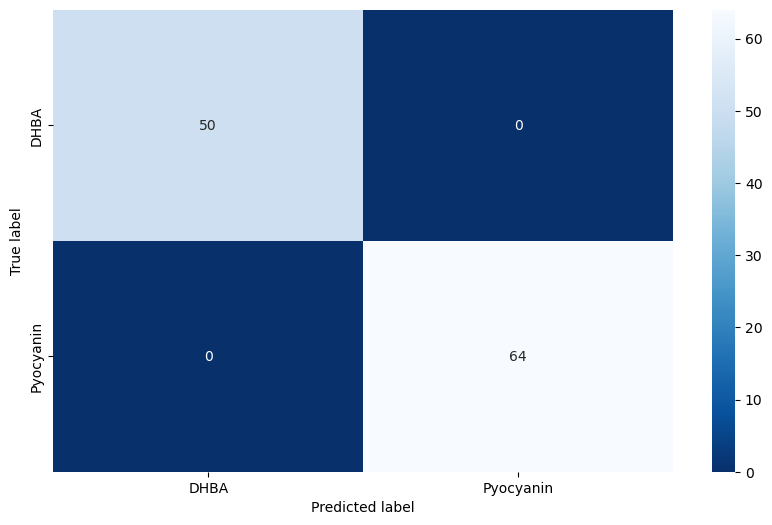

In [34]:
# Draw the confusion matrix
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True,fmt="d",cmap='Blues_r')
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

Draw the ROC curve, and output the AUC value for all classes.

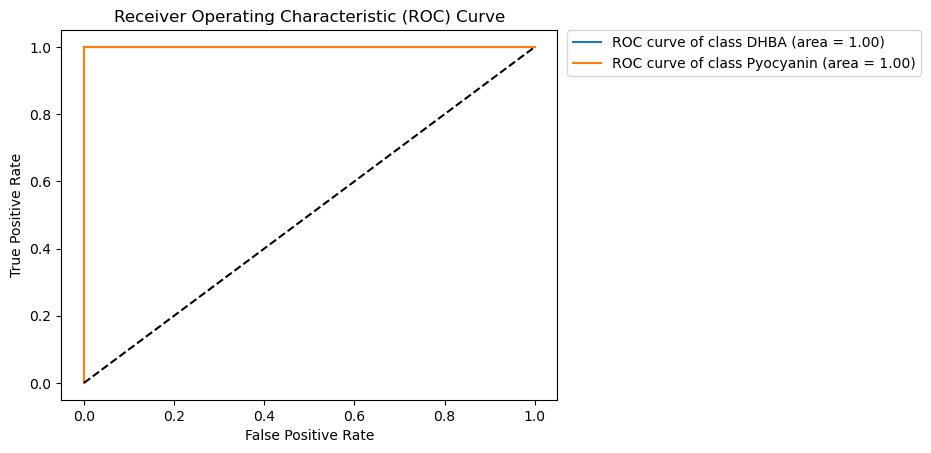

In [35]:
# Get predicted probabilities for each class
svc_pred_prob = svc.predict_proba(X_test)

# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(svc.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_class[:, i], svc_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_class.ravel(), svc_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curve for each class
plt.figure()
colormap = plt.cm.tab10
for i in range(len(svc.classes_)):
    color = colormap(i)
    plt.plot(fpr[i], tpr[i], color=color, label="ROC curve of class {0} (area = {1:0.2f})".format(index[i], roc_auc[i]),)

# Plot the micro-average ROC curve
# plt.plot(fpr["micro"], tpr["micro"], color='black', linestyle='--', label='Micro-average ROC curve (area = %0.2f)' % roc_auc["micro"])

# Plot the random chance line
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
# Move the legend outside the plot area
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.show()

#### k-fold Cross-Validation using SVM
Divide the training set into $k$-folds, use one fold of them as the testing set, and others as the training set. In this way, we can train a model on $k$ possible (training set, testing set) combinations. So we can calculate mean accuracy and error bar,

Please indicate the `k` (default: $5$) below.

In [36]:
# k-fold Cross-Validation
k = 5
print('Performing {}-fold Cross-Validation'.format(k))
scores = cross_val_score(svc, X_train, y_train_class_label, cv=k)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy: %0.5f, standard deviation: %0.5f" % (np.array(scores).mean(), np.array(scores).std()))

Performing 5-fold Cross-Validation
Cross-validation scores: [0.78947368 1.         1.         1.         1.        ]
Mean accuracy: 0.95789, standard deviation: 0.08421


In [38]:
# See the coefficients of SVM (only with linear kernel)
# svc.coef_

In [ ]:
# Save the coefficients of SVM
# np.savetxt(WORKING_PATH + "/result/svm_coef.csv", abs(svc.coef_), delimiter=",")

A simple way (occlusion: set the feature to 0, and see the drop percentage of performance) to calculate feature importance of this SVM.
Note:
1. This code block may take a long time.
2. This feature importance method may not be accurate and is only used to provide a preliminary understanding of the model.

In [ ]:
# Calculate the baseline accuracy
baseline_accuracy = accuracy_score(y_test_class_label, svc_pred)

FI = []
for i in trange(len(wavenumbers)):
    # Set a feature to 0
    X_test_modified = X_test.copy()  # Make a copy of the testing data
    X_test_modified[:, i] = 0  # Modify a feature to 0

    # Calculate accuracy or decision values with the modified data
    modified_accuracy = accuracy_score(y_test_class_label, svc.predict(X_test_modified))

    FI.append((baseline_accuracy - modified_accuracy) / baseline_accuracy)


In [ ]:
# Save the feature importance scores
FI_results = pd.DataFrame({'wavenumbers':wavenumbers,'FI':FI})
# pd.DataFrame(FI_results).to_csv(WORKING_PATH + "/result/FI_results.csv",index=False)

In [ ]:
# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.bar(wavenumbers, FI)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

Other two ways that may calculate the feature importance, but they are not guaranteed to work, or to be correct. They are just saved here for future use.

In [ ]:
# # Get the indices of the support vectors
# support_vector_indices = svc.support_

# # Get the corresponding coefficients for the support vectors
# support_vector_coefs = svc.dual_coef_[0]

# # Get the feature names
# feature_names = train.columns

# # Sort the coefficients in descending order and get the corresponding feature names
# sorted_features = [feature for _, feature in sorted(zip(support_vector_coefs, feature_names), reverse=True)]

# # Plot the feature importances
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(sorted_features)), support_vector_coefs)
# plt.xlabel('Features')
# plt.ylabel('Importance')
# plt.title('Feature Importances')
# plt.tight_layout()
# plt.show()

In [ ]:
# coefficients = svc.coef_[0]
# feature_names = train.columns

# # Sort the coefficients in descending order and get the corresponding feature names
# sorted_features = [feature for _, feature in sorted(zip(coefficients, feature_names), reverse=True)]
    
# # Plot the feature importances
# plt.figure(figsize=(10, 6))
# plt.bar(wavenumbers, coefficients)
# plt.xlabel('Features')
# plt.ylabel('Importance')
# plt.title('Feature Importances')
# plt.tight_layout()
# plt.show()

#### Random Forest Classification

Random Forest (RF) is another kind of powerful classifier. This model is based on decision trees structure.

When working with RF, the choice of these parameters is important:

1. `n_estimators`: It represents the number of decision trees in the random forest. A higher number of estimators can improve the performance of the model but may increase computation time. The default value is `100`.

2. `criterion`: It specifies the function to measure the quality of a split. The two commonly used criteria are `"gini"` for the Gini impurity and `"entropy"` for information gain. The default value is `"gini"`.

3. `max_depth`: It defines the maximum depth of each decision tree in the random forest. **A deeper tree can capture more complex relationships in the data but can also lead to overfitting**. The default value is `None`, which means the tree will be expanded until all leaves are pure.

In [55]:
rf = RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=None, n_jobs=-1, verbose=2)
rf.fit(X_train, y_train_class_label)
rf_pred = rf.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.0s


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [56]:
# Comparing results
print("Accuracy:",accuracy_score(np.argmax(y_test_class, axis=1), rf_pred))
print("Precision:",precision_score(np.argmax(y_test_class, axis=1), rf_pred, average='macro'))
print("Recall:",recall_score(np.argmax(y_test_class, axis=1), rf_pred, average='macro'))
print("F1 score:",f1_score(np.argmax(y_test_class, axis=1), rf_pred, average='macro'))

Accuracy: 0.9803921568627451
Precision: 0.9833333333333332
Recall: 0.9800000000000001
F1 score: 0.9807780320366133


In [57]:
# confusion matrix
cm = confusion_matrix(np.argmax(y_test_class, axis=1), rf_pred)
index = encoder.categories_[0]
columns = encoder.categories_[0]
cm_df = pd.DataFrame(cm,columns,index)  

# Save the confusion matrix
# pd.DataFrame(cm_df).to_csv(WORKING_PATH + "/result/cm_df_RF.csv",index=False)

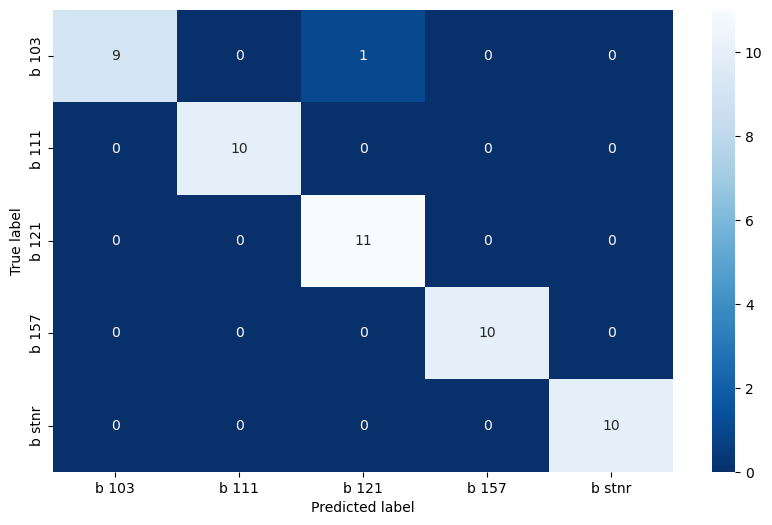

In [58]:
# Draw the confusion matrix
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True,fmt="d",cmap='Blues_r')
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


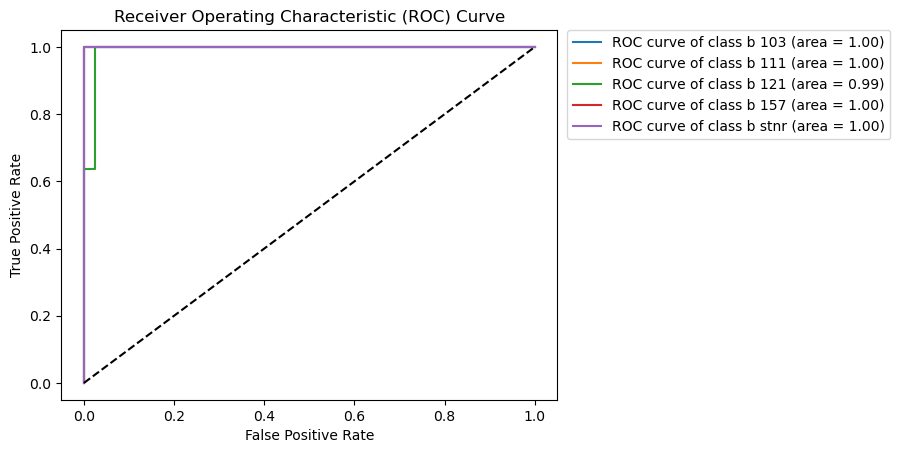

In [59]:
## Draw the ROC curve
# Get predicted probabilities for each class
rf_pred_prob = rf.predict_proba(X_test)

# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(rf.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_class[:, i], rf_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_class.ravel(), rf_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curve for each class
plt.figure()
colormap = plt.cm.tab10
for i in range(len(rf.classes_)):
    color = colormap(i)
    plt.plot(fpr[i], tpr[i], color=color, label="ROC curve of class {0} (area = {1:0.2f})".format(index[i], roc_auc[i]),)

# Plot the micro-average ROC curve
# plt.plot(fpr["micro"], tpr["micro"], color='black', linestyle='--', label='Micro-average ROC curve (area = %0.2f)' % roc_auc["micro"])

# Plot the random chance line
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
# Move the legend outside the plot area
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.show()

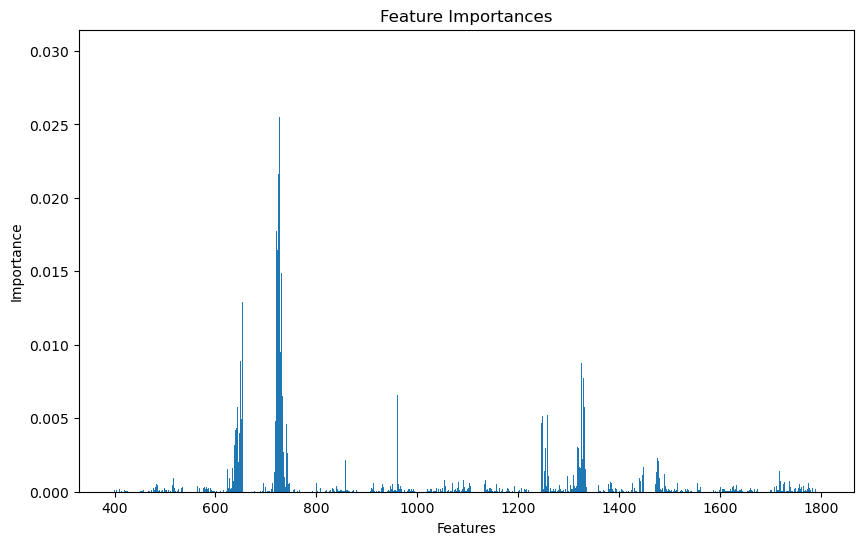

In [60]:
# Feature Importance plot
plt.figure(figsize=(10, 6))
plt.bar(wavenumbers, rf.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

#### k-fold Cross-Validation using RF
Please indicate the `k` (default: $5$) below.

Note: it may take a long time to run if `k` and `n_estimators` are large.

In [61]:
# k-fold Cross-Validation
k = 5
print('Performing {}-fold Cross-Validation'.format(k))
scores = cross_val_score(svc, X_train, y_train_class_label, cv=k)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy: %0.5f, standard deviation: %0.5f" % (np.array(scores).mean(), np.array(scores).std()))

Performing 5-fold Cross-Validation
Cross-validation scores: [0.97777778 1.         1.         0.98876404 0.97752809]
Mean accuracy: 0.98881, standard deviation: 0.00999


#### PLS-DA

Partial Least Squares Discriminant Analysis (PLS-DA) is a classification algorithm that combines elements of both PLS regression for supervised dimensionality reduction and Linear Discriminant Analysis (LDA) classification.

The choice of `n_components` in PLS regression is important.

We should choose an `n_components` that captures a significant portion (0.9-0.95) of the variance in the data. Please use the following code to see the `R^2` (portion of the variance) vs `n_components` and choose the corresponding `n_components`.

Note:
1. Please change the range of `n_components` to examine by modifying `n_components_range`.
2. A common rule of thumb is to set `n_components` to $min$(number of features, number of samples).
3. If `n_components` is large, the computation time would be very long. **If a small `n_components` can't get good results, please do not use PLS-DA!**

In [62]:
# Please change the range of n_components to draw in the following plot
n_components_range = range(1, 21)

explained_variance = []
for n in n_components_range:
    pls = PLSRegression(n_components=n)
    pls.fit(X_train, y_train_class_label)

    # Calculate R^2 for each component
    r2_scores = pls.score(X_train, y_train_class_label)

    # Calculate cumulative explained variance
    explained_variance.append(np.sum(r2_scores))


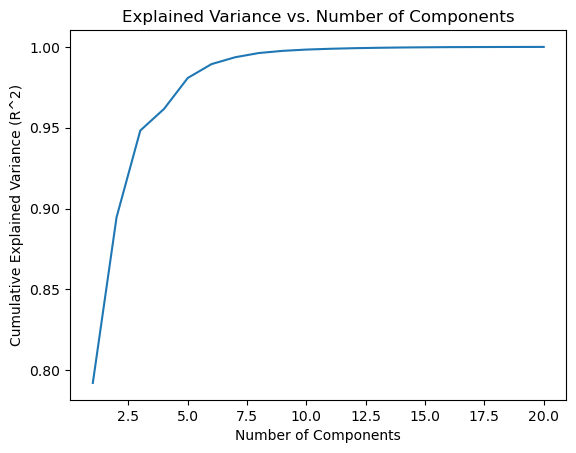

In [63]:
# Plot the cumulative explained variance
plt.plot(n_components_range, explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (R^2)')
plt.title('Explained Variance vs. Number of Components')
plt.show()

Choose a `n_components` that has $R^2 > 0.9$, then use that `n_components` to do `PLSRegression.`

In [64]:
# Perform PLS regression
pls = PLSRegression(n_components=20) # Change n_components here.
X_pls = pls.fit_transform(X_train, y_train_class_label)

# Perform LDA on the PLS components
lda = LinearDiscriminantAnalysis()
X_pls_lda = lda.fit_transform(X_pls[0], y_train_class_label)

# Access the transformed features and class labels
X_pls_lda

array([[ 2.25471260e+02,  4.23370013e+00, -2.09793228e+00,
        -2.93675690e-01],
       [ 2.24687397e+02,  4.85693813e+00, -1.47785575e+00,
         9.28300134e-01],
       [ 2.24691027e+02,  5.49704613e+00, -8.25086119e-01,
        -4.07107687e+00],
       ...,
       [-2.30543084e+02,  7.35750702e-01, -2.26951691e+00,
         1.37205762e-01],
       [-2.29789434e+02,  1.34581270e+00, -4.76118615e+00,
        -5.46369861e-01],
       [-2.30723966e+02,  6.13387767e-01, -3.88261020e+00,
        -1.35283255e+00]])

In [65]:
# Split the data into training and testing sets
X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(X_pls_lda, y_train_class_label, test_size=0.2)

# Perform classification using LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_lda, y_train_lda)

# Predict the class labels for the testing data
y_pred = lda.predict(X_test_lda)

In [66]:
# Comparing results
print("Accuracy:",accuracy_score(y_test_lda, y_pred))
print("Precision:",precision_score(y_test_lda, y_pred, average='macro'))
print("Recall:",recall_score(y_test_lda, y_pred, average='macro'))
print("F1 score:",f1_score(y_test_lda, y_pred, average='macro'))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0


In [67]:
# confusion matrix
cm = confusion_matrix(y_test_lda, y_pred)
index = encoder.categories_[0]
columns = encoder.categories_[0]
cm_df = pd.DataFrame(cm,columns,index)  

# Save the confusion matrix
# pd.DataFrame(cm_df).to_csv(WORKING_PATH + "/result/cm_df_RF.csv",index=False)

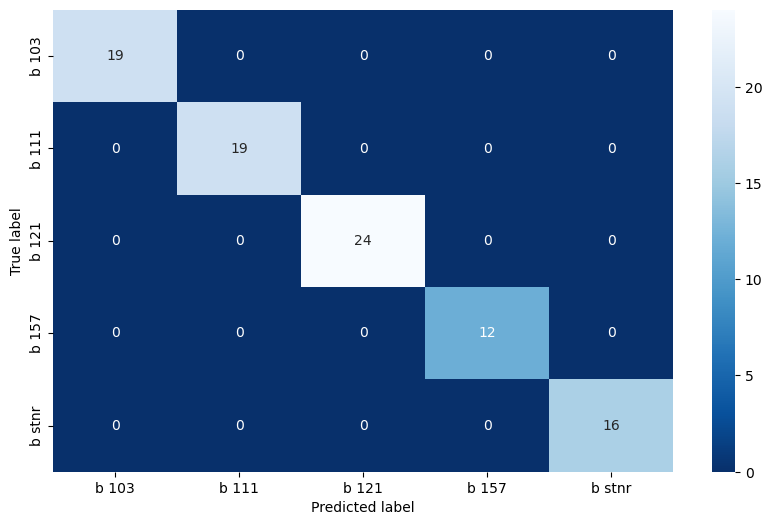

In [68]:
# Draw the confusion matrix
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True,fmt="d",cmap='Blues_r')
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

**Note: this ROC curve may be wrong! Use it with caution!**

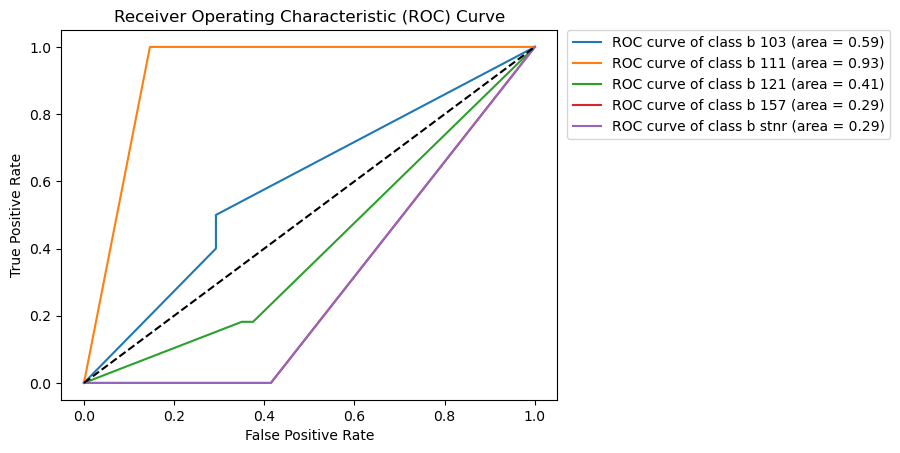

In [69]:
# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Perform LDA on the PLS components
lda = LinearDiscriminantAnalysis()
X_pls_lda = lda.fit_transform(X_pls[0], y_train_class_label)
X_plsda = pls.transform(X_test)

for i in range(len(lda.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_class[:, i], lda.predict_proba(X_plsda)[:,1])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure()
colormap = plt.cm.tab10
for i in range(len(lda.classes_)):
    color = colormap(i)
    plt.plot(fpr[i], tpr[i], color=color, label="ROC curve of class {0} (area = {1:0.2f})".format(index[i], roc_auc[i]))

# Plot the random chance line
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
# Move the legend outside the plot area
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.show()

### Regression
#### Note: the regression task may be much more difficult than classification tasks, thus may not get good results using these traditional models!

#### SVR (Support Vector Regression)

SVR is the regression version of SVM.

When working with SVR, the kernel types remain the same, but the parameters changed.

1. Linear Kernel(`kernel='linear'`).

2. Polynomial Kernel (`kernel='poly', degree=degree, coef0=coef0, C=C, epsilon=epsilon`).
   - The degree of the polynomial can be specified using the `degree` parameter (default: 3). Higher polynomial degrees can capture more complex relationships but may also be prone to overfitting if the degree is too high.
   - The `coef0` parameter (default: 0.0) controls the influence of high-degree polynomials compared to low-degree polynomials.
   - The `C` parameter (default: 1.0) represents the regularization parameter. Higher values of `C` allow for more training errors to be made, potentially leading to overfitting; while lower values enforce a larger margin and may result in underfitting.
   - The `epsilon` parameter (default: 0.1) represents the sensitivity of the model to errors. A smaller `epsilon` may result in a model that is more sensitive to noise and outliers but provides a more precise fit to the training data. Conversely, a larger `epsilon` can lead to a more robust model but with potentially less accuracy in fitting the training data.

3. Radial Basis Function (RBF) Kernel (`kernel='rbf', gamma=gamma, C=C, epsilon=epsilon`).
   - The `gamma` parameter (default: $\frac{1}{n_{features} X.var()}$) controls the smoothness of the decision boundary. A smaller `gamma` value creates a smoother boundary, while a larger `gamma` value can lead to a more complex and intricate decision boundary.
   - The `C` parameter and the `epsilon` parameter are the same as the polynomial kernel.

**After choosing the kernel, you need to make several trials to find out the best parameters.**

In [74]:
# Create a svr
svr = svm.SVR(kernel = 'rbf', C=100, epsilon=0.001)
# sklearn.svr only accept label vectors as input, not one-hot vectors.

y_train_reg_label = np.max(y_train_reg, axis=1)
with parallel_backend('threading', n_jobs=-1):
    # Fit the SVC model
    svr.fit(X_train, y_train_reg_label)
svr_pred = svr.predict(X_test)

In [75]:
# Comparing results
y_test_reg_label = np.max(y_test_reg, axis=1)
print("MAE:",mean_absolute_error(y_test_reg_label, svr_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test_reg_label, svr_pred)))
print("R^2:",r2_score(y_test_reg_label, svr_pred))

MAE: 0.10795915716955441
RMSE: 0.18435811049330175
R^2: 0.9755789007515425


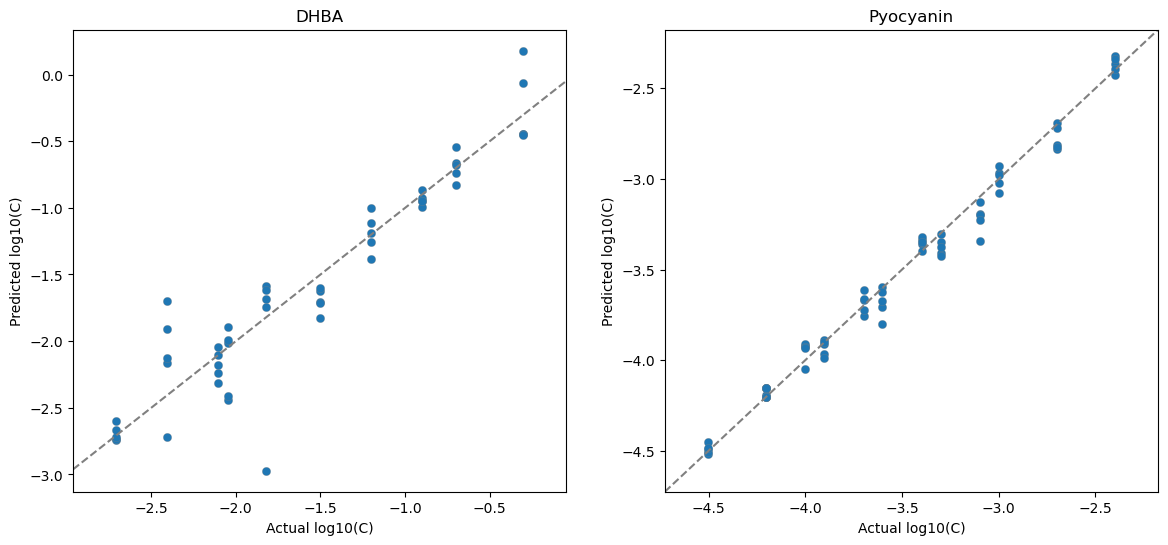

Classes: ['DHBA' 'Pyocyanin']
MAEs: [0.1761231632016261, 0.05470602745699836]
MAEs: [0.26594190773642623, 0.07271166909087724]
Rsquareds: [0.8721767022692546, 0.9855189273077508]


In [76]:
## Draw calibration curve (predicted vs actual concentration)
indices = [np.where(y_test_reg[:, i] != -50) for i in range(len(labels))]
MAEs = []
RMSEs = []
Rsquareds = []

# Calculate the number of rows and columns for the subplots
num_rows = (len(labels) + 1) // 2  # Round up to the nearest integer
num_cols = min(2, len(labels))  # Maximum of 2 columns
plt.figure(figsize=(14, 6*num_rows))

for i in range(len(labels)):
    # Calculate MAE, RMSE, and R^2 for each index
    MAE = mean_absolute_error(y_test_reg[indices[i], i][0], svr_pred[indices[i]])
    RMSE = np.sqrt(mean_squared_error(y_test_reg[indices[i], i][0], svr_pred[indices[i]]))
    Rsquared = r2_score(y_test_reg[indices[i], i][0], svr_pred[indices[i]])
    MAEs.append(MAE)
    RMSEs.append(RMSE)
    Rsquareds.append(Rsquared)

    # Create subplots
    plt.subplot(num_rows, num_cols, i + 1)
    plt.scatter(y_test_reg[indices[i], i][0], svr_pred[indices[i]], edgecolors="grey", linewidths=0.2)
    plt.axline([plt.xlim()[0], plt.xlim()[0]], [plt.xlim()[1], plt.xlim()[1]], linestyle='--', color="grey")
    plt.xlabel("Actual log10(C)")
    plt.ylabel("Predicted log10(C)")
    plt.title(labels[i])
    
plt.show()

# Print MAE and R^2 lists
print("Classes:", labels)
print("MAEs:", MAEs)
print("MAEs:", RMSEs)
print("Rsquareds:", Rsquareds)

A simple way (occlusion: set the feature to 0, and see the drop percentage of performance) to calculate feature importance of this SVR.
Note:
1. This code block may take a long time.
2. This feature importance method may not be accurate and is only used to provide a preliminary understanding of the model.

In [ ]:
# Calculate the baseline accuracy
baseline_r2 = r2_score(y_test_reg_label, svr_pred)

FI = []
for i in trange(len(wavenumbers)):
    # Set a feature to 0
    X_test_modified = X_test.copy()  # Make a copy of the testing data
    X_test_modified[:, i] = 0  # Modify a feature to 0

    # Calculate accuracy or decision values with the modified data
    modified_r2 = r2_score(y_test_reg_label, svr.predict(X_test_modified))

    FI.append((baseline_r2 - modified_r2) / baseline_r2)


In [ ]:
# Save the feature importance scores
FI_results = pd.DataFrame({'wavenumbers':wavenumbers,'FI':FI})
# pd.DataFrame(FI_results).to_csv(WORKING_PATH + "/result/FI_results.csv",index=False)

In [ ]:
# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.bar(wavenumbers, FI)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

#### Random Forest Regression

Random Forest (RF) can also do regression.

When working with RF, the choice of these parameters is important:

1. `n_estimators`: It represents the number of decision trees in the random forest. A higher number of estimators can improve the performance of the model but may increase computation time. The default value is `100`.

2. `criterion`: For regression, the commonly used criteria are `"squared_error"` (MSE) and `"absolute_error"` (MAE). Please use `"squared_error"` if there are many outliers in the dataset; otherwise, use `"absolute_error"`.

3. `max_depth`: It defines the maximum depth of each decision tree in the random forest. **A deeper tree can capture more complex relationships in the data but can also lead to overfitting**. The default value is `None`, which means the tree will be expanded until all leaves are pure.

In [96]:
rf = RandomForestRegressor(n_estimators=100, criterion="absolute_error", max_depth=None, n_jobs=-1, verbose=2)
rf.fit(X_train, y_train_reg_label)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.4s


building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.6s finished


RandomForestRegressor(criterion='absolute_error', n_jobs=-1, verbose=2)

In [97]:
rf_pred = rf.predict(X_test)

# Comparing results
print("MAE:",mean_absolute_error(y_test_reg_label, rf_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test_reg_label, rf_pred)))
print("R^2:",r2_score(y_test_reg_label, rf_pred))

MAE: 0.19256811846790978
RMSE: 0.22781925314453763
R^2: 0.9061968752685026


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


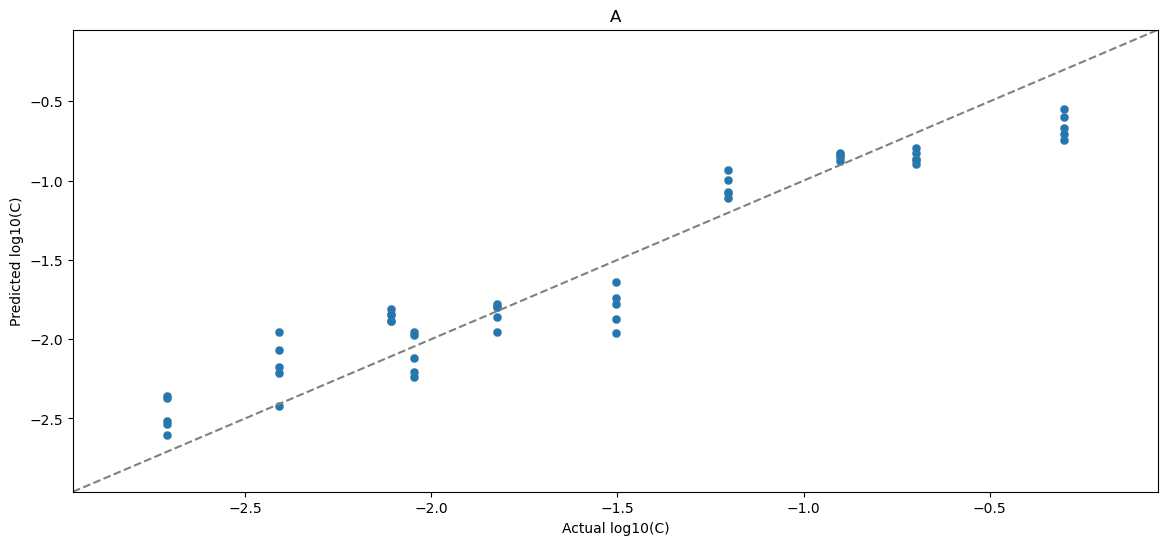

Classes: ['A']
MAEs: [0.19256811846790978]
MAEs: [0.22781925314453763]
Rsquareds: [0.9061968752685026]


In [98]:
## Draw calibration curve (predicted vs actual concentration)
indices = [np.where(y_test_reg[:, i] != 0) for i in range(len(labels))]
MAEs = []
RMSEs = []
Rsquareds = []

# Calculate the number of rows and columns for the subplots
num_rows = (len(labels) + 1) // 2  # Round up to the nearest integer
num_cols = min(2, len(labels))  # Maximum of 2 columns
plt.figure(figsize=(14, 6*num_rows))

for i in range(len(labels)):
    # Calculate MAE, RMSE, and R^2 for each index
    MAE = mean_absolute_error(y_test_reg[indices[i], i][0], rf_pred[indices[i]])
    RMSE = np.sqrt(mean_squared_error(y_test_reg[indices[i], i][0], rf_pred[indices[i]]))
    Rsquared = r2_score(y_test_reg[indices[i], i][0], rf_pred[indices[i]])
    MAEs.append(MAE)
    RMSEs.append(RMSE)
    Rsquareds.append(Rsquared)

    # Create subplots
    plt.subplot(num_rows, num_cols, i + 1)
    plt.scatter(y_test_reg[indices[i], i][0], rf_pred[indices[i]], edgecolors="grey", linewidths=0.2)
    plt.axline([plt.xlim()[0], plt.xlim()[0]], [plt.xlim()[1], plt.xlim()[1]], linestyle='--', color="grey")
    plt.xlabel("Actual log10(C)")
    plt.ylabel("Predicted log10(C)")
    plt.title(labels[i])
    
plt.show()

# Print MAE and R^2 lists
print("Classes:", labels)
print("MAEs:", MAEs)
print("MAEs:", RMSEs)
print("Rsquareds:", Rsquareds)

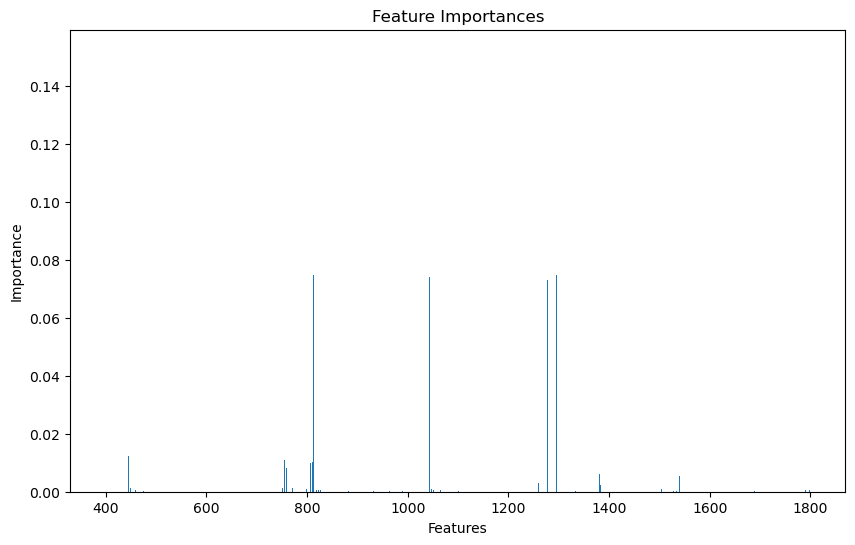

In [61]:
# Feature Importance plot
plt.figure(figsize=(10, 6))
plt.bar(wavenumbers, rf.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

#### PLS

The choice of `n_components` in PLS regression is important.

We should choose an `n_components` that captures a significant portion (0.9-0.95) of the variance in the data. Please use the following code to see the `R^2` (portion of the variance) vs `n_components` and choose the corresponding `n_components`.

Note:
1. Please change the range of `n_components` to examine by modifying `n_components_range`.
2. A common rule of thumb is to set `n_components` to $min$(number of features, number of samples).
3. If `n_components` is large, the computation time would be very long. **If a small `n_components` can't get good results, please do not use PLS-DA!**

In [62]:
# Please change the range of n_components to draw in the following plot
n_components_range = range(1, 21)

explained_variance = []
for n in n_components_range:
    pls = PLSRegression(n_components=n)
    pls.fit(X_train, y_train_reg_label)

    # Calculate R^2 for each component
    r2_scores = pls.score(X_train, y_train_reg_label)

    # Calculate cumulative explained variance
    explained_variance.append(np.sum(r2_scores))


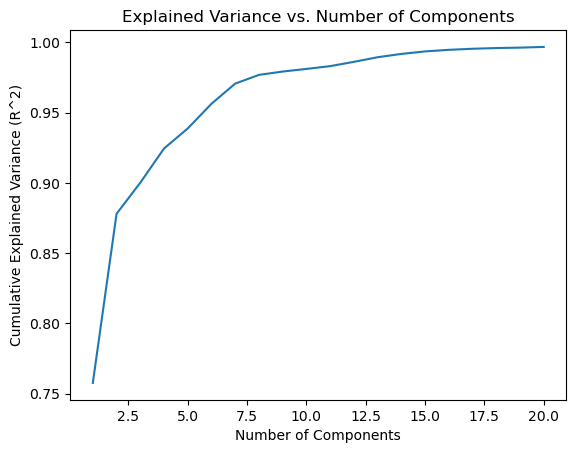

In [63]:
# Plot the cumulative explained variance
plt.plot(n_components_range, explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (R^2)')
plt.title('Explained Variance vs. Number of Components')
plt.show()

Choose a `n_components` that has $R^2 > 0.9$, then use that `n_components` to do `PLSRegression.`

In [64]:
# Perform PLS regression
pls = PLSRegression(n_components=200) # Change n_components here.
pls.fit(X_train, y_train_reg_label)
y_pred_pls = pls.predict(X_test)

D:\Anaconda\Lib\site-packages\sklearn\cross_decomposition\_pls.py:300: UserWarning:

Y residual is constant at iteration 78



In [65]:
# Comparing results
print("MAE:",mean_absolute_error(y_test_reg_label, y_pred_pls))
print("MSE:",np.sqrt(mean_squared_error(y_test_reg_label, y_pred_pls)))
print("R^2:",r2_score(y_test_reg_label, y_pred_pls))

MAE: 0.14800110026045823
MSE: 0.20167310833473215
R^2: 0.9264923663666058


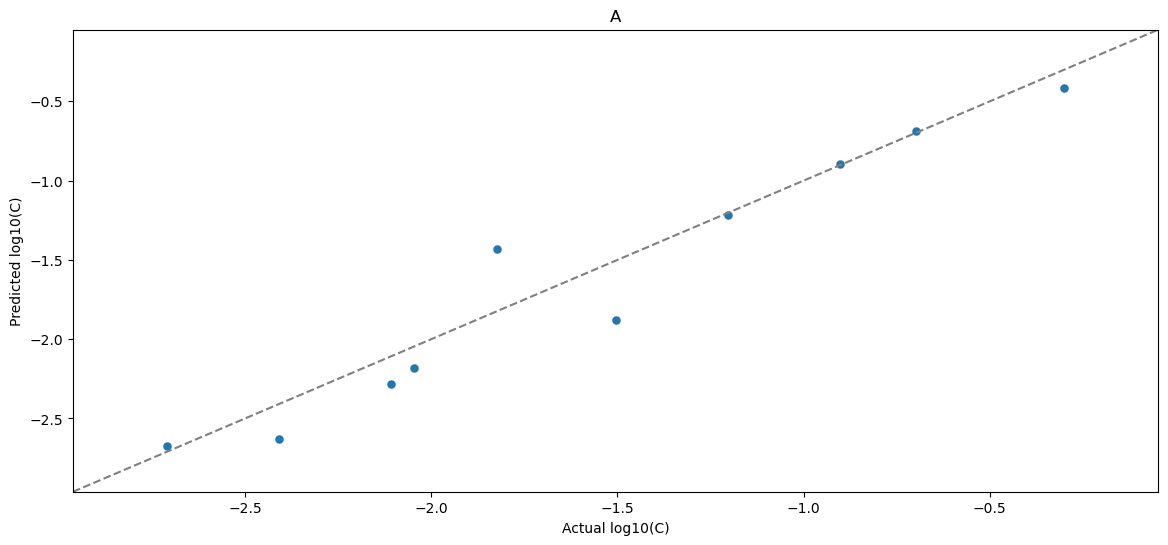

Classes: ['A']
MAEs: [0.14800110026045823]
MAEs: [0.20167310833473215]
Rsquareds: [0.9264923663666058]


In [66]:
## Draw calibration curve (predicted vs actual concentration)
indices = [np.where(y_test_reg[:, i] != 0) for i in range(len(labels))]
MAEs = []
RMSEs = []
Rsquareds = []

# Calculate the number of rows and columns for the subplots
num_rows = (len(labels) + 1) // 2  # Round up to the nearest integer
num_cols = min(2, len(labels))  # Maximum of 2 columns
plt.figure(figsize=(14, 6*num_rows))

for i in range(len(labels)):
    # Calculate MAE, RMSE, and R^2 for each index
    MAE = mean_absolute_error(y_test_reg[indices[i], i][0], y_pred_pls[indices[i]])
    RMSE = np.sqrt(mean_squared_error(y_test_reg[indices[i], i][0], y_pred_pls[indices[i]]))
    Rsquared = r2_score(y_test_reg[indices[i], i][0], y_pred_pls[indices[i]])
    MAEs.append(MAE)
    RMSEs.append(RMSE)
    Rsquareds.append(Rsquared)

    # Create subplots
    plt.subplot(num_rows, num_cols, i + 1)
    plt.scatter(y_test_reg[indices[i], i][0], y_pred_pls[indices[i]], edgecolors="grey", linewidths=0.2)
    plt.axline([plt.xlim()[0], plt.xlim()[0]], [plt.xlim()[1], plt.xlim()[1]], linestyle='--', color="grey")
    plt.xlabel("Actual log10(C)")
    plt.ylabel("Predicted log10(C)")
    plt.title(labels[i])
    
plt.show()

# Print MAE and R^2 lists
print("Classes:", labels)
print("MAEs:", MAEs)
print("MAEs:", RMSEs)
print("Rsquareds:", Rsquareds)

#### As we can see, if the input data contains multiple classes, it's hard to use traditional machine learning models to do regression.

#### If we separate the data into single classes, and train a separate model on every class, results will be much better.

For example, we can select a single label (`selected_label`) and re-run a classification model:

In [85]:
# Select training data with a specific label
selected_label = 'b 103'  # Replace with the label you want to select
selected_data_train = train[train['Label'] == selected_label] # split training data
selected_data_train

,400,401,402,403,404,405,406,407,408,409,...,1789,1790,1791,1792,1793,1794,1795,1796,Label,Conc
6,-0.214488,-0.084982,1.546815,-1.012436,0.675029,1.884463,-0.936948,-2.914470,-1.465513,0.393225,...,0.857207,2.149944,1.398822,0.382012,0.649902,1.141561,-0.728591,-1.196799,b 103,0.1
61,-3.261019,0.309052,0.259099,-0.799065,-0.752898,0.253383,0.393773,-0.703194,-1.284226,-0.270093,...,-0.262415,0.399756,1.250130,1.427541,-1.157526,1.173231,-0.206126,-0.468372,b 103,0.1
0,-1.247152,0.934963,2.916187,-1.240702,-0.307359,-0.487516,0.478045,0.319687,-0.564098,-0.268240,...,1.088214,0.862162,1.091616,0.504338,0.106900,0.219846,0.832890,-1.224048,b 103,0.1
37,-2.351594,-2.127015,-1.634981,-0.311344,-0.534023,-1.045475,-0.919485,1.349075,1.625514,0.193232,...,-0.841977,0.928775,0.098163,2.268344,0.061879,0.465676,0.587415,-0.748364,b 103,0.1
69,0.923474,-0.312289,0.304604,-0.293610,0.495284,-0.563651,-0.051172,1.446983,1.256225,0.449107,...,1.055818,0.492503,0.291627,-0.043957,1.770533,-0.098474,0.746029,0.785665,b 103,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,1.938788,-1.428440,-0.332486,-1.181530,0.604285,1.155373,2.602274,2.558647,0.956377,2.135829,...,0.880570,-0.152766,-0.079914,-0.615739,2.291047,0.786642,-1.275179,-1.118697,b 103,0.1
14,2.472309,2.153936,2.074824,1.897694,0.009899,0.285155,-1.013961,-1.214947,-0.490969,-0.401595,...,1.628856,2.049578,0.411517,-0.921191,-0.775426,-1.294812,1.035254,-0.597871,b 103,0.1
67,2.567717,2.375257,1.492573,-0.167687,1.325537,2.058699,1.034027,1.066203,1.062148,0.371652,...,1.419436,0.275549,0.268284,1.078775,1.661199,1.126102,1.298054,-1.125504,b 103,0.1
53,-1.478642,1.206044,0.677257,-0.164429,1.183054,1.020273,0.526863,1.430496,1.173787,-0.071246,...,0.108316,0.189177,-0.675065,-0.421091,0.102673,-1.755247,-1.819609,-2.509891,b 103,0.1


In [86]:
# Get the indices of the selected data
selected_indices_train = selected_data_train.index
selected_indices_train

Int64Index([ 6, 61,  0, 37, 69, 30, 17,  4, 29, 59, 76, 38, 56, 68, 32, 73, 91,
             9, 84, 64, 35, 77, 90, 89,  7, 22,  3, 95, 51, 87, 92, 31, 85, 11,
            86, 60, 34, 41, 71, 52, 13, 49, 79, 54, 16, 78, 93, 24, 33, 70, 66,
            26,  8, 48, 80, 40, 98, 58, 10, 96,  5, 44, 83, 75, 81, 55, 21, 39,
            57, 20, 25, 27, 28, 72, 46, 62, 36, 82, 43,  1, 15, 18, 47, 45, 94,
            14, 67, 53, 23],
           dtype='int64')

In [87]:
# Get new X_train and y_train_reg
X_train_split = selected_data_train.values[:,:-2]
y_train_reg_split = np.log10(selected_data_train.values[:,-1].astype(float)+1e-20) # we only need the regression part.

In [88]:
# Similarly, select testing data with the specific label
selected_data_test = test[test['Label'] == selected_label] # split testing data
selected_data_test

,400,401,402,403,404,405,406,407,408,409,...,1789,1790,1791,1792,1793,1794,1795,1796,Label,Conc
2,0.259440,3.234944,0.330268,0.659744,0.994859,0.210130,-0.164252,0.156134,0.752121,0.668704,...,1.276281,-1.318219,-0.160003,4.471874,-0.839566,1.471571,-0.331423,0.097565,b 103,0.1
12,-4.107405,-2.003956,-3.389282,-1.345804,0.308234,0.896179,-0.658771,0.958150,2.826366,0.666769,...,-0.537303,1.528113,2.000849,0.721583,-0.197428,-0.232727,-0.130703,0.250856,b 103,0.1
19,1.384639,1.102749,0.793117,-0.213766,0.412909,1.798018,1.941721,1.143975,0.968626,1.074210,...,0.380117,0.250975,-0.474665,0.546372,-0.784709,0.680453,-0.253294,0.221559,b 103,0.1
42,-1.240299,-0.584169,-3.104088,-0.745344,-2.759763,0.038509,0.518986,-0.068444,-0.618341,-0.298001,...,2.266607,1.603135,0.595143,-2.053815,1.316763,-0.167937,0.149139,0.409680,b 103,0.1
50,0.029793,0.279290,0.337733,0.853792,0.950806,0.631176,-1.298197,-0.107568,0.846799,0.133387,...,1.495851,0.527483,0.445430,-0.442400,-0.688803,-0.310339,-0.379110,-0.213530,b 103,0.1
63,0.262154,0.344394,0.007719,-0.504283,-0.709468,0.093569,1.619230,2.014508,1.186752,0.066996,...,1.285552,2.401671,1.831619,1.592694,-0.587989,-0.001604,0.468445,0.643376,b 103,0.1
65,-0.254300,2.116008,0.562442,1.379056,0.201908,0.945835,0.856754,0.907896,0.567011,-0.986582,...,0.040719,0.827926,0.884822,0.705826,0.604414,1.403775,-0.343343,-0.328267,b 103,0.1
74,1.889410,0.104150,-0.013649,0.379543,0.250636,0.217656,0.535179,1.006996,0.442073,-0.267158,...,0.932990,0.148224,-0.665886,-0.007212,-0.743353,-1.454338,-0.294839,0.520054,b 103,0.1
88,1.488788,2.553463,3.947217,0.934361,-0.336378,-3.721832,-0.481188,1.684792,2.128534,3.524023,...,4.023084,1.567309,1.364338,0.934156,-1.023530,0.419584,0.034596,2.191534,b 103,0.1
97,-0.199064,0.926238,-0.116189,2.081385,1.072906,-0.098114,-0.817445,-0.511463,-0.108249,-1.263963,...,-1.249095,0.660508,1.703513,0.891224,1.391591,1.896490,-0.871825,0.704735,b 103,0.1


In [89]:
# Get the indices of the selected data
selected_indices_test = selected_data_test.index
selected_indices_test

Int64Index([2, 12, 19, 42, 50, 63, 65, 74, 88, 97], dtype='int64')

In [90]:
# Get new X_train and y_train_reg
X_test_split = selected_data_test.values[:,:-2]
y_test_reg_split = np.log10(selected_data_test.values[:,-1].astype(float)+1e-20) # we only need the regression part.

Then we do SVR, RF again.

In [91]:
# Create a svr
svr = svm.SVR(kernel = 'rbf', C = 10000, epsilon = 0.5)
# sklearn.svr only accept label vectors as input, not one-hot vectors.
y_train_reg_split_label = y_train_reg_split
with parallel_backend('threading', n_jobs=-1):
    # Fit the SVR model
    svr.fit(X_train_split, y_train_reg_split_label)
svr_pred = svr.predict(X_test_split)

In [92]:
# Comparing results
y_test_reg_split_label = y_test_reg_split
print("MAE:",mean_absolute_error(y_test_reg_split_label, svr_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test_reg_split_label, svr_pred)))
print("R^2:",r2_score(y_test_reg_split_label, svr_pred))

MAE: 0.0
RMSE: 0.0
R^2: 1.0


Text(0.5, 1.0, 'b 103')

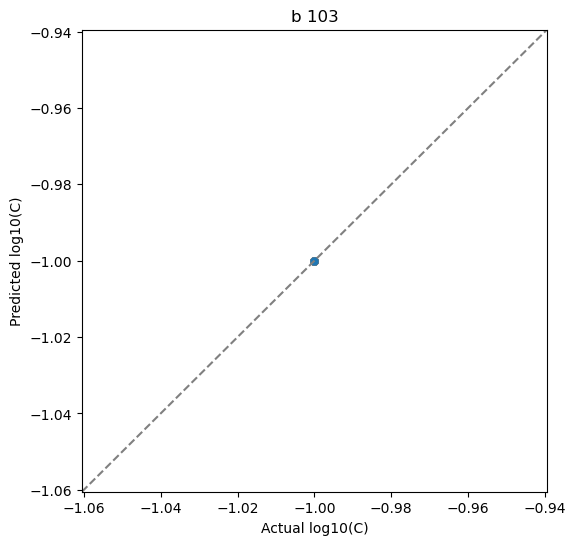

In [93]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test_reg_split, svr_pred, edgecolors="grey", linewidths=0.2)
plt.axline([plt.xlim()[0], plt.xlim()[0]], [plt.xlim()[1], plt.xlim()[1]], linestyle='--', color="grey")
plt.xlabel("Actual log10(C)")
plt.ylabel("Predicted log10(C)")
plt.title(selected_label)

Now let's use RF.

In [136]:
rf = RandomForestRegressor(n_estimators=10, criterion="squared_error", max_depth=10, n_jobs=-1, verbose=2)
rf.fit(X_train_split, y_train_reg_split_label)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 10building tree 2 of 10

building tree 3 of 10building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10

building tree 9 of 10building tree 10 of 10



[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    1.1s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished


RandomForestRegressor(max_depth=10, n_estimators=10, n_jobs=-1, verbose=2)

In [137]:
rf_pred = rf.predict(X_test_split)

# Comparing results
print("MAE:",mean_absolute_error(y_test_reg_split_label, svr_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test_reg_split_label, svr_pred)))
print("R^2:",r2_score(y_test_reg_split_label, svr_pred))

MAE: 0.17155737824022463
RMSE: 0.2175605136437487
R^2: 0.9472181795196437


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


Text(0.5, 1.0, 'NL63')

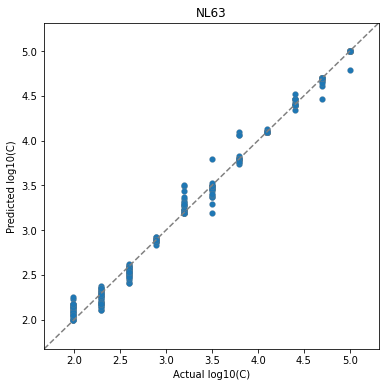

In [138]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test_reg_split, rf_pred, edgecolors="grey", linewidths=0.2)
plt.axline([plt.xlim()[0], plt.xlim()[0]], [plt.xlim()[1], plt.xlim()[1]], linestyle='--', color="grey")
plt.xlabel("Actual log10(C)")
plt.ylabel("Predicted log10(C)")
plt.title(selected_label)